In [57]:
# Customer Segmentation using K-Means Clustering
# For Internship Project - Online Retail Dataset

## Importing Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from datetime import datetime, timedelta
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('fivethirtyeight')
%matplotlib inline

In [58]:
## Load and Explore the Online Retail Dataset
# Load the dataset
df = pd.read_excel('Online Retail.xlsx')

# Explore the dataset
print("Dataset Overview:")
print(df.head())
print(f"\nDataset Shape: {df.shape}")
print("\nDataset Info:")
print(df.info())
print("\nBasic Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Check unique values
print("\nUnique Values:")
print(f"Customers: {df['CustomerID'].nunique()}")
print(f"Products: {df['StockCode'].nunique()}")
print(f"Countries: {df['Country'].nunique()}")
print(f"Invoices: {df['InvoiceNo'].nunique()}")

Dataset Overview:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  

Dataset Shape: (541909, 8)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       

Original shape: (541909, 8)
After removing rows with missing CustomerID: (406829, 8)
Final cleaned dataset shape: (397884, 9)
Final unique customers: 4338

Cleaned Data Overview:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalAmount  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom        15.30  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom        20.34  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom        22.00  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom        20.34  
4 2010-1

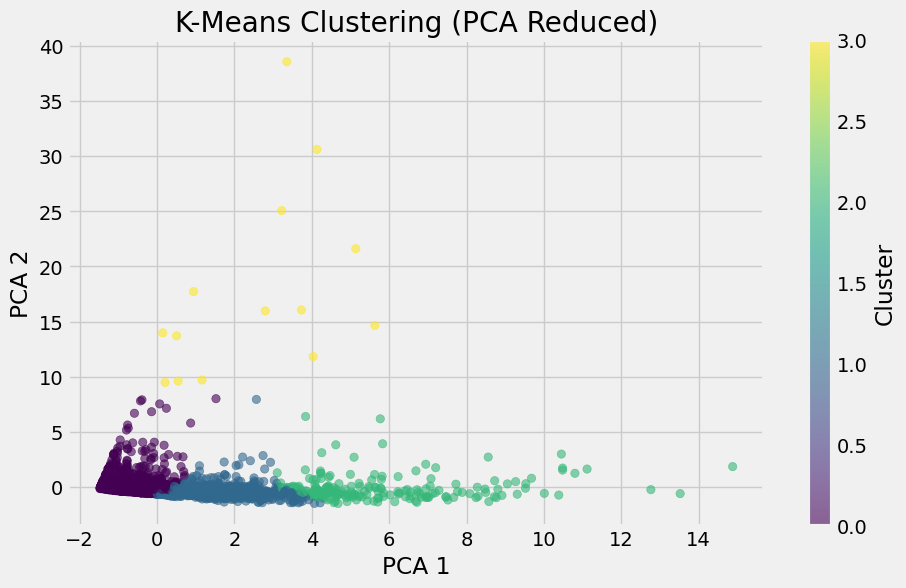


DBSCAN cluster labels: [-1  0  1  2]
Cluster sizes: [ 466 3752    7    5]


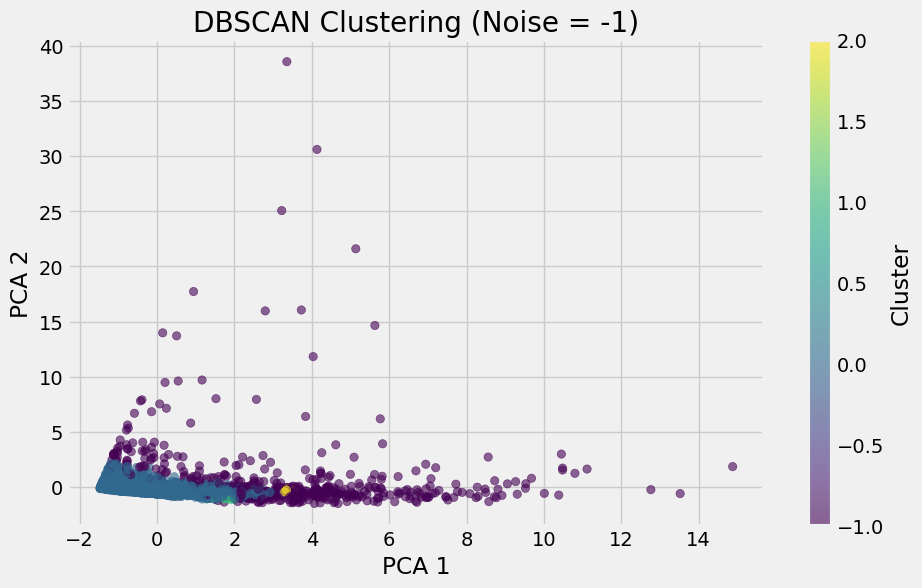

In [59]:

# -------------------------------
# Data Cleaning and Preprocessing
# -------------------------------
print(f"Original shape: {df.shape}")
df_clean = df.dropna(subset=['CustomerID'])
print(f"After removing rows with missing CustomerID: {df_clean.shape}")

# Remove canceled orders
df_clean = df_clean[~df_clean['InvoiceNo'].astype(str).str.startswith('C')]

# Convert InvoiceDate to datetime
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

# Calculate total amount
df_clean['TotalAmount'] = df_clean['Quantity'] * df_clean['UnitPrice']

# Remove negative quantities and prices
df_clean = df_clean[df_clean['Quantity'] > 0]
df_clean = df_clean[df_clean['UnitPrice'] > 0]

print(f"Final cleaned dataset shape: {df_clean.shape}")
print(f"Final unique customers: {df_clean['CustomerID'].nunique()}")

print("\nCleaned Data Overview:")
print(df_clean.head())

# -------------------------------
# Feature Engineering for Clustering
# -------------------------------
customer_features = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': ['nunique'],      # Purchase frequency
    'Quantity': ['sum', 'mean'],     # Total quantity, avg per transaction
    'TotalAmount': ['sum', 'mean'],  # Total spent, avg spend
    'StockCode': 'nunique'           # Unique products purchased
}).reset_index()

# Flatten column names
customer_features.columns = [
    'CustomerID',
    'PurchaseFrequency',
    'TotalQuantity',
    'AvgQuantity',
    'TotalSpend',
    'AvgSpend',
    'UniqueProducts'
]

print("\nEngineered Features:")
print(customer_features.head())

# -------------------------------
# Data Preprocessing for Clustering
# -------------------------------
features_for_clustering = [
    'PurchaseFrequency',
    'TotalQuantity',
    'AvgQuantity',
    'TotalSpend',
    'AvgSpend',
    'UniqueProducts'
]
X = customer_features[features_for_clustering]

print("\nSelected Features for Clustering:")
print(X.head())

# Outlier removal using Z-score
z_scores = np.abs(stats.zscore(X))
filtered_mask = (z_scores < 3).all(axis=1)
X_filtered = X[filtered_mask]

print(f"\nOriginal samples: {len(X)}")
print(f"After outlier removal: {len(X_filtered)}")
print(f"Outliers removed: {len(X) - len(X_filtered)}")

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filtered)
X_scaled_df = pd.DataFrame(X_scaled, columns=features_for_clustering, index=X_filtered.index)

print("\nScaled Features (first 5 rows):")
print(X_scaled_df.head())

# -------------------------------
# KMeans Clustering
# -------------------------------
optimal_k = 4  # Choose from Elbow/Silhouette methods
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20, max_iter=300)
kmeans.fit(X_scaled)
X_scaled_df['Cluster'] = kmeans.labels_

print("\nCluster sizes (KMeans):")
print(X_scaled_df['Cluster'].value_counts().sort_index())

# PCA visualization for KMeans
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.6)
plt.title('K-Means Clustering (PCA Reduced)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.show()

# -------------------------------
# DBSCAN Clustering
# -------------------------------
dbscan = DBSCAN(eps=0.5, min_samples=5)
db_labels = dbscan.fit_predict(X_scaled)

print("\nDBSCAN cluster labels:", np.unique(db_labels))
print("Cluster sizes:", np.bincount(db_labels + 1))  # +1 to handle -1 noise

# PCA visualization for DBSCAN
X_pca_db = pca.fit_transform(X_scaled)
plt.figure(figsize=(10, 6))
plt.scatter(X_pca_db[:, 0], X_pca_db[:, 1], c=db_labels, cmap='viridis', alpha=0.6)
plt.title('DBSCAN Clustering (Noise = -1)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.show()


In [60]:
## RFM Analysis (Recency, Frequency, Monetary)
# Set reference date (one day after the last invoice date)
reference_date = df_clean['InvoiceDate'].max() + timedelta(days=1)

# Calculate RFM values for each customer
rfm_df = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalAmount': 'sum'  # Monetary
}).reset_index()

# Rename columns
rfm_df.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

print("RFM DataFrame Overview:")
print(rfm_df.head())
print(f"\nRFM DataFrame Shape: {rfm_df.shape}")
print("\nRFM Statistics:")
print(rfm_df.describe())

RFM DataFrame Overview:
   CustomerID  Recency  Frequency  Monetary
0     12346.0      326          1  77183.60
1     12347.0        2          7   4310.00
2     12348.0       75          4   1797.24
3     12349.0       19          1   1757.55
4     12350.0      310          1    334.40

RFM DataFrame Shape: (4338, 4)

RFM Statistics:
         CustomerID      Recency    Frequency       Monetary
count   4338.000000  4338.000000  4338.000000    4338.000000
mean   15300.408022    92.536422     4.272015    2054.266460
std     1721.808492   100.014169     7.697998    8989.230441
min    12346.000000     1.000000     1.000000       3.750000
25%    13813.250000    18.000000     1.000000     307.415000
50%    15299.500000    51.000000     2.000000     674.485000
75%    16778.750000   142.000000     5.000000    1661.740000
max    18287.000000   374.000000   209.000000  280206.020000


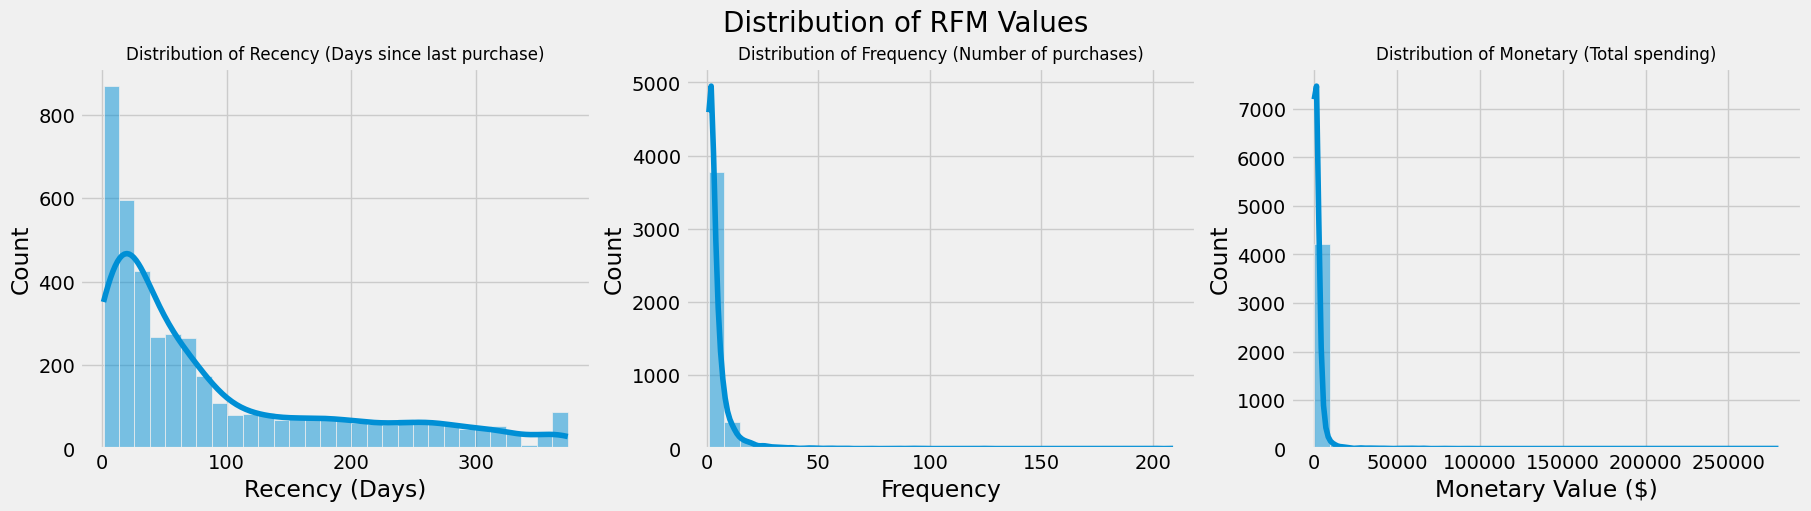

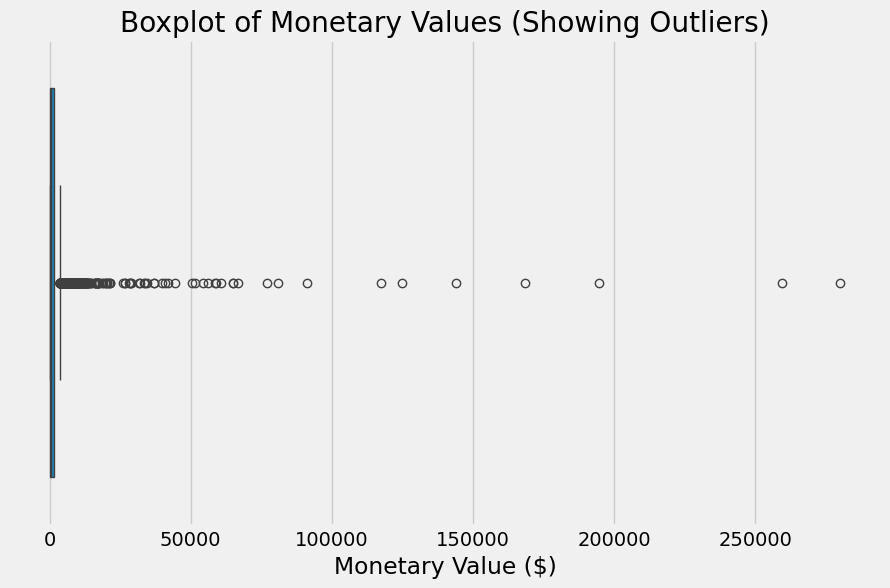

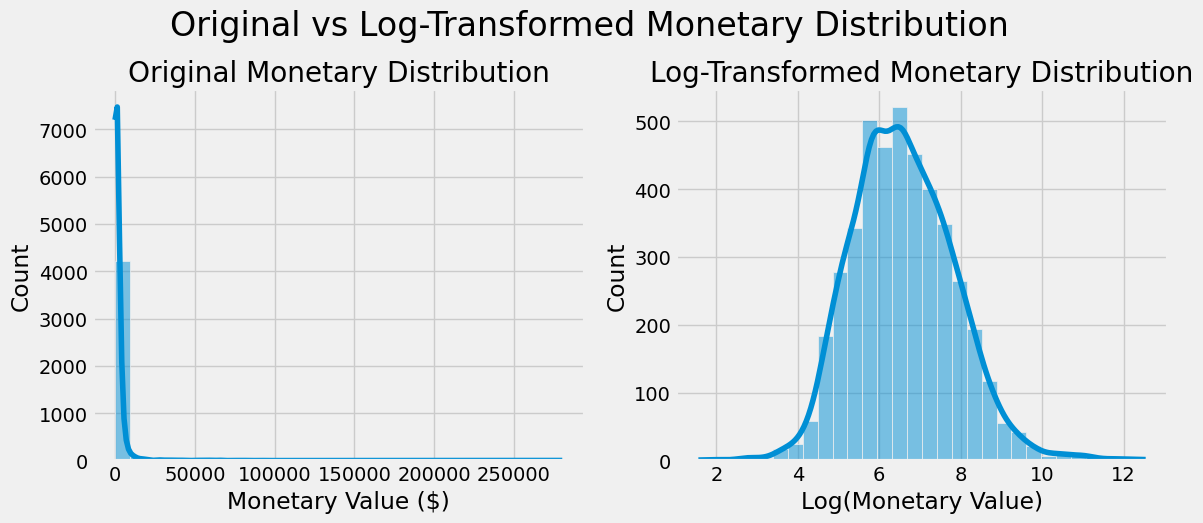

In [61]:
## Exploratory Data Analysis of RFM Values
fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)
fig.suptitle('Distribution of RFM Values', fontsize=20)  # Larger main title

# Recency
sns.histplot(rfm_df['Recency'], ax=axes[0], kde=True, bins=30)
axes[0].set_title('Distribution of Recency (Days since last purchase)', fontsize=12)  # Smaller subplot title
axes[0].set_xlabel('Recency (Days)')

# Frequency
sns.histplot(rfm_df['Frequency'], ax=axes[1], kde=True, bins=30)
axes[1].set_title('Distribution of Frequency (Number of purchases)', fontsize=12)
axes[1].set_xlabel('Frequency')

# Monetary
sns.histplot(rfm_df['Monetary'], ax=axes[2], kde=True, bins=30)
axes[2].set_title('Distribution of Monetary (Total spending)', fontsize=12)
axes[2].set_xlabel('Monetary Value ($)')
axes[2].ticklabel_format(style='plain', axis='x')

plt.show()


# Check for outliers in Monetary values
plt.figure(figsize=(10, 6))
sns.boxplot(x=rfm_df['Monetary'])
plt.title('Boxplot of Monetary Values (Showing Outliers)')
plt.xlabel('Monetary Value ($)')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

# Log transformation for Monetary to handle outliers
rfm_df['MonetaryLog'] = np.log1p(rfm_df['Monetary'])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(rfm_df['Monetary'], kde=True, bins=30)
plt.title('Original Monetary Distribution')
plt.xlabel('Monetary Value ($)')
plt.ticklabel_format(style='plain', axis='x')

plt.subplot(1, 2, 2)
sns.histplot(rfm_df['MonetaryLog'], kde=True, bins=30)
plt.title('Log-Transformed Monetary Distribution')
plt.xlabel('Log(Monetary Value)')

plt.suptitle('Original vs Log-Transformed Monetary Distribution', fontsize=24, y=1.05)
plt.tight_layout(rect=[0, 0, 1, 1.10])
plt.show()

In [62]:
## Additional Features for Clustering
# Calculate additional customer metrics
customer_metrics = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': ['min', 'max', 'nunique'],  # First purchase, last purchase, unique days
    'StockCode': 'nunique',  # Unique products purchased
    'Quantity': ['sum', 'mean'],  # Total quantity, average quantity per transaction
    'Country': 'nunique'  # Number of countries shopped from
}).reset_index()

# Flatten column names
customer_metrics.columns = ['CustomerID', 'FirstPurchase', 'LastPurchase', 'UniquePurchaseDays', 
                           'UniqueProducts', 'TotalQuantity', 'AvgQuantity', 'UniqueCountries']

# Calculate customer lifetime in days
customer_metrics['CustomerLifetime'] = (customer_metrics['LastPurchase'] - customer_metrics['FirstPurchase']).dt.days

# Calculate average spending per day
customer_metrics['AvgSpendPerDay'] = customer_metrics['TotalQuantity'] / customer_metrics['CustomerLifetime'].replace(0, 1)

# Merge with RFM data
customer_features = pd.merge(rfm_df, customer_metrics, on='CustomerID')

# Select final features for clustering
features_for_clustering = ['Recency', 'Frequency', 'MonetaryLog', 'UniqueProducts', 
                          'TotalQuantity', 'CustomerLifetime', 'AvgSpendPerDay']

X = customer_features.set_index('CustomerID')[features_for_clustering]


print("Final Features for Clustering:")
print(X.head())
print(f"\nShape: {X.shape}")
print("\nDescription:")
print(X.describe())

Final Features for Clustering:
            Recency  Frequency  MonetaryLog  UniqueProducts  TotalQuantity  \
CustomerID                                                                   
12346.0         326          1    11.253955               1          74215   
12347.0           2          7     8.368925             103           2458   
12348.0          75          4     7.494564              22           2341   
12349.0          19          1     7.472245              73            631   
12350.0         310          1     5.815324              17            197   

            CustomerLifetime  AvgSpendPerDay  
CustomerID                                    
12346.0                    0    74215.000000  
12347.0                  365        6.734247  
12348.0                  282        8.301418  
12349.0                    0      631.000000  
12350.0                    0      197.000000  

Shape: (4338, 7)

Description:
           Recency    Frequency  MonetaryLog  UniqueProducts 

In [63]:
## Data Preprocessing for Clustering
# Check for missing values
print("Missing values in features:")
print(X.isnull().sum())

# Handle any missing values (if any)
X_clean = X.dropna()

# Normalizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

# Convert back to DataFrame for better readability
X_scaled_df = pd.DataFrame(X_scaled, columns=features_for_clustering, index=X_clean.index)

print("Scaled Features Overview:")
print(X_scaled_df.describe().round(2))

Missing values in features:
Recency             0
Frequency           0
MonetaryLog         0
UniqueProducts      0
TotalQuantity       0
CustomerLifetime    0
AvgSpendPerDay      0
dtype: int64
Scaled Features Overview:
       Recency  Frequency  MonetaryLog  UniqueProducts  TotalQuantity  \
count  4338.00    4338.00      4338.00         4338.00        4338.00   
mean      0.00       0.00         0.00           -0.00          -0.00   
std       1.00       1.00         1.00            1.00           1.00   
min      -0.92      -0.43        -4.00           -0.71          -0.24   
25%      -0.75      -0.43        -0.69           -0.53          -0.20   
50%      -0.42      -0.30        -0.06           -0.31          -0.16   
75%       0.49       0.09         0.65            0.18          -0.04   
max       2.81      26.60         4.73           20.22          38.79   

       CustomerLifetime  AvgSpendPerDay  
count           4338.00         4338.00  
mean               0.00           -0.

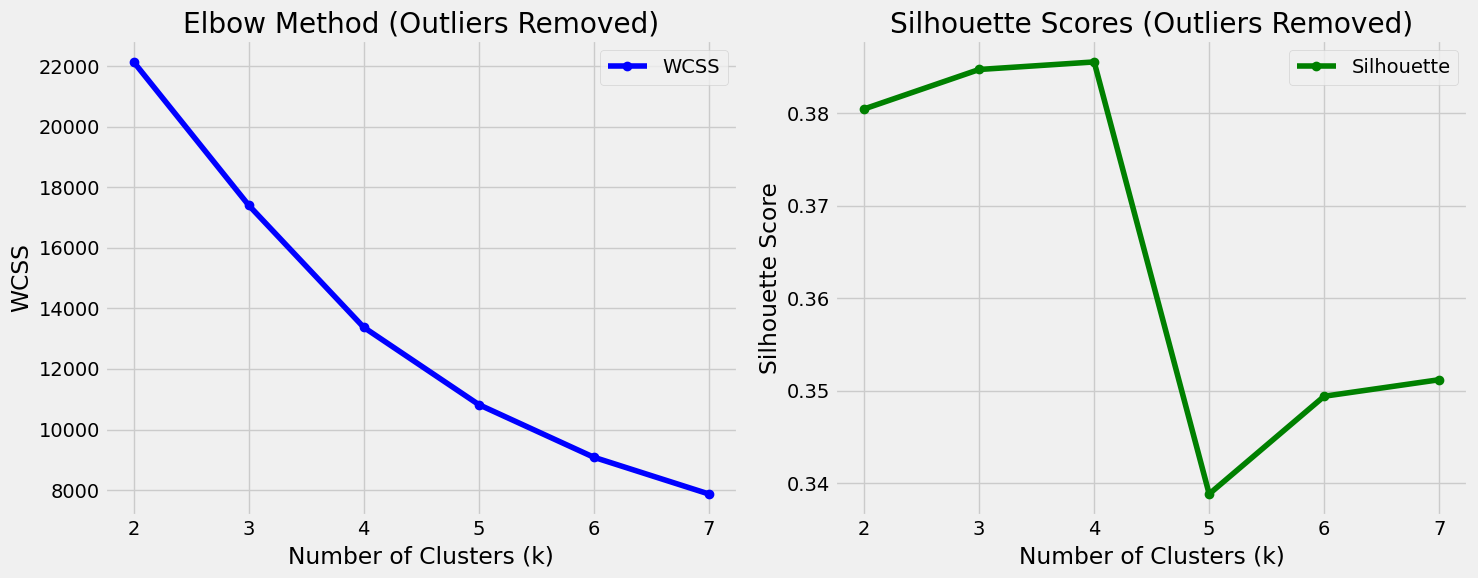


Silhouette Scores:
k=2: Silhouette=0.380
k=3: Silhouette=0.385
k=4: Silhouette=0.386
k=5: Silhouette=0.339
k=6: Silhouette=0.349
k=7: Silhouette=0.351

Selected optimal k: 3


In [64]:
## Determining Optimal Number of Clusters (with Outliers Removed)
wcss = []
silhouette_scores = []
k_range = range(2, 8)  # test fewer clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20, max_iter=300)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
    
    if k > 1:
        silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(k_range, wcss, 'bo-', label='WCSS')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method (Outliers Removed)')
plt.xticks(k_range)
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(2, 8), silhouette_scores, 'go-', label='Silhouette')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores (Outliers Removed)')
plt.xticks(range(2, 8))
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

print("\nSilhouette Scores:")
for k, score in zip(range(2, 8), silhouette_scores):
    print(f"k={k}: Silhouette={score:.3f}")

optimal_k = 3  # Based on elbow + silhouette
print(f"\nSelected optimal k: {optimal_k}")


Cluster sizes:
Cluster
0    3503
1     641
2      86
Name: count, dtype: int64


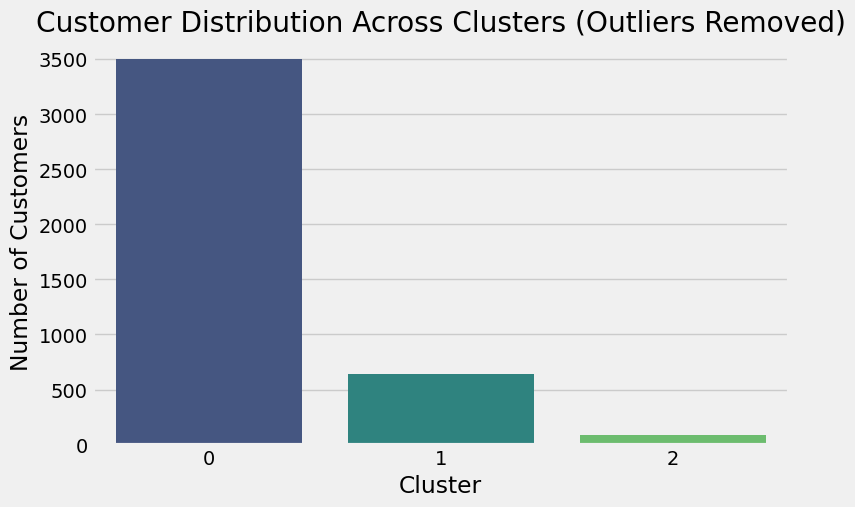

Number of features in clustering: 6
Number of features scaler was fitted on: 7

Cluster Centers (Original Scale):
   Recency  Frequency  MonetaryLog  UniqueProducts  TotalQuantity  \
0    22.92      11.06         8.34          151.11        2934.13   
1   153.51       1.34         5.67           23.20         242.34   
2    45.67       3.94         6.97           62.44         755.67   

   CustomerLifetime  AvgSpendPerDay  Cluster  
0            298.82           12.74        0  
1             15.92          180.50        1  
2            203.46            6.64        2  


In [73]:
# -------------------------------
# Applying K-Means Clustering (with Outliers Removed)
# -------------------------------

# Fit KMeans on the scaled, filtered data
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20, max_iter=300)
kmeans.fit(X_filtered)

# Subset customer_features to only rows that were kept after outlier removal
customer_clusters = customer_features.loc[X_filtered.index].copy()
customer_clusters.reset_index(drop=True, inplace=True)

# Assign cluster labels
customer_clusters['Cluster'] = kmeans.labels_

print("Cluster sizes:")
cluster_counts = customer_clusters['Cluster'].value_counts().sort_index()
print(cluster_counts)

# Plot cluster distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')
plt.title('Customer Distribution Across Clusters (Outliers Removed)')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()

# Check the number of features
print(f"Number of features in clustering: {X_filtered.shape[1]}")
print(f"Number of features scaler was fitted on: {scaler.scale_.shape[0]}")

# Create a new scaler fitted only on the filtered data with the correct number of features
scaler_filtered = StandardScaler()
X_filtered_scaled = scaler_filtered.fit_transform(customer_features.loc[X_filtered.index, features_for_clustering])

# Re-fit KMeans if necessary (optional, since we already have labels)
kmeans_filtered = KMeans(n_clusters=optimal_k, random_state=42, n_init=20, max_iter=300)
kmeans_filtered.fit(X_filtered_scaled)

# Compute cluster centers in original scale using the correct scaler
cluster_centers_original = scaler_filtered.inverse_transform(kmeans_filtered.cluster_centers_)
cluster_centers_df = pd.DataFrame(cluster_centers_original, columns=features_for_clustering)
cluster_centers_df['Cluster'] = range(optimal_k)

print("\nCluster Centers (Original Scale):")
print(cluster_centers_df.round(2))

<Figure size 1500x1200 with 0 Axes>

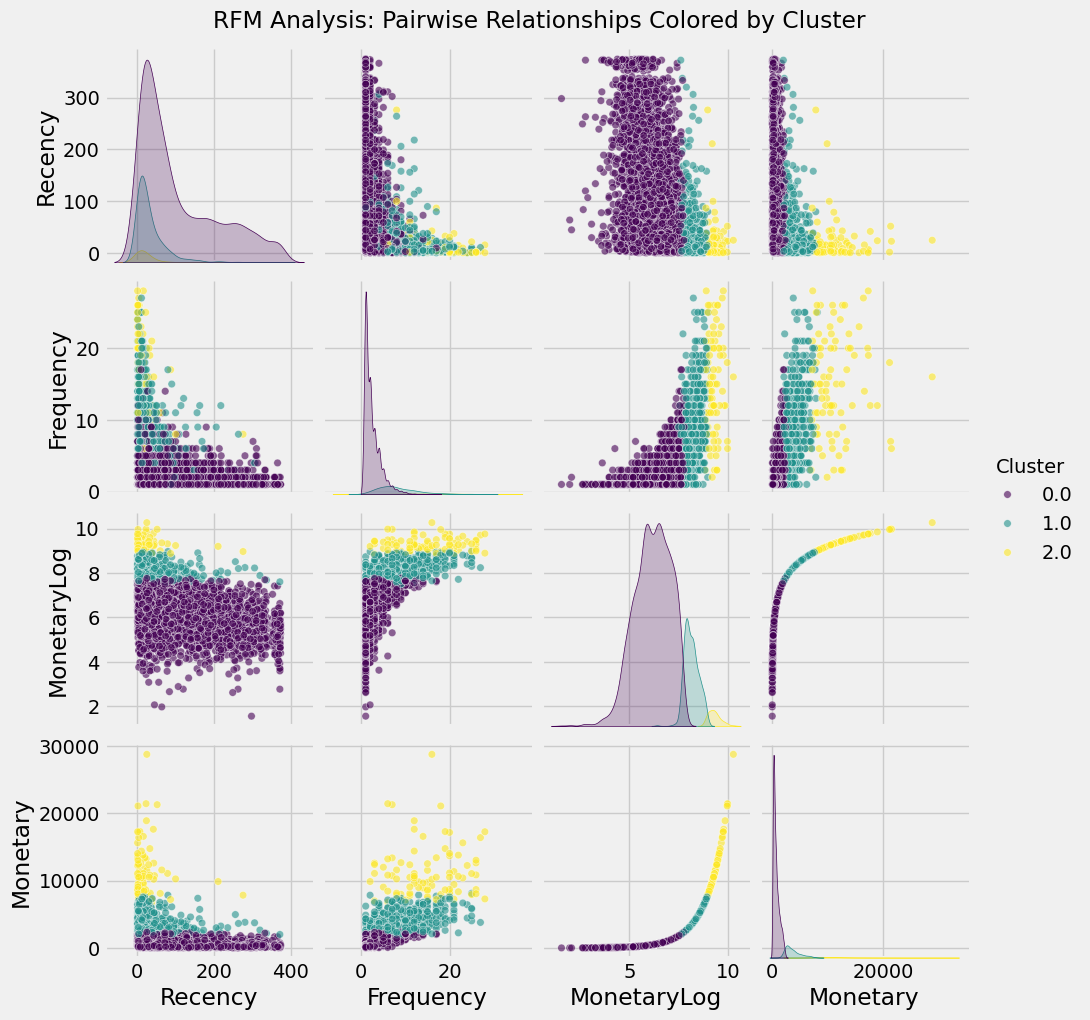

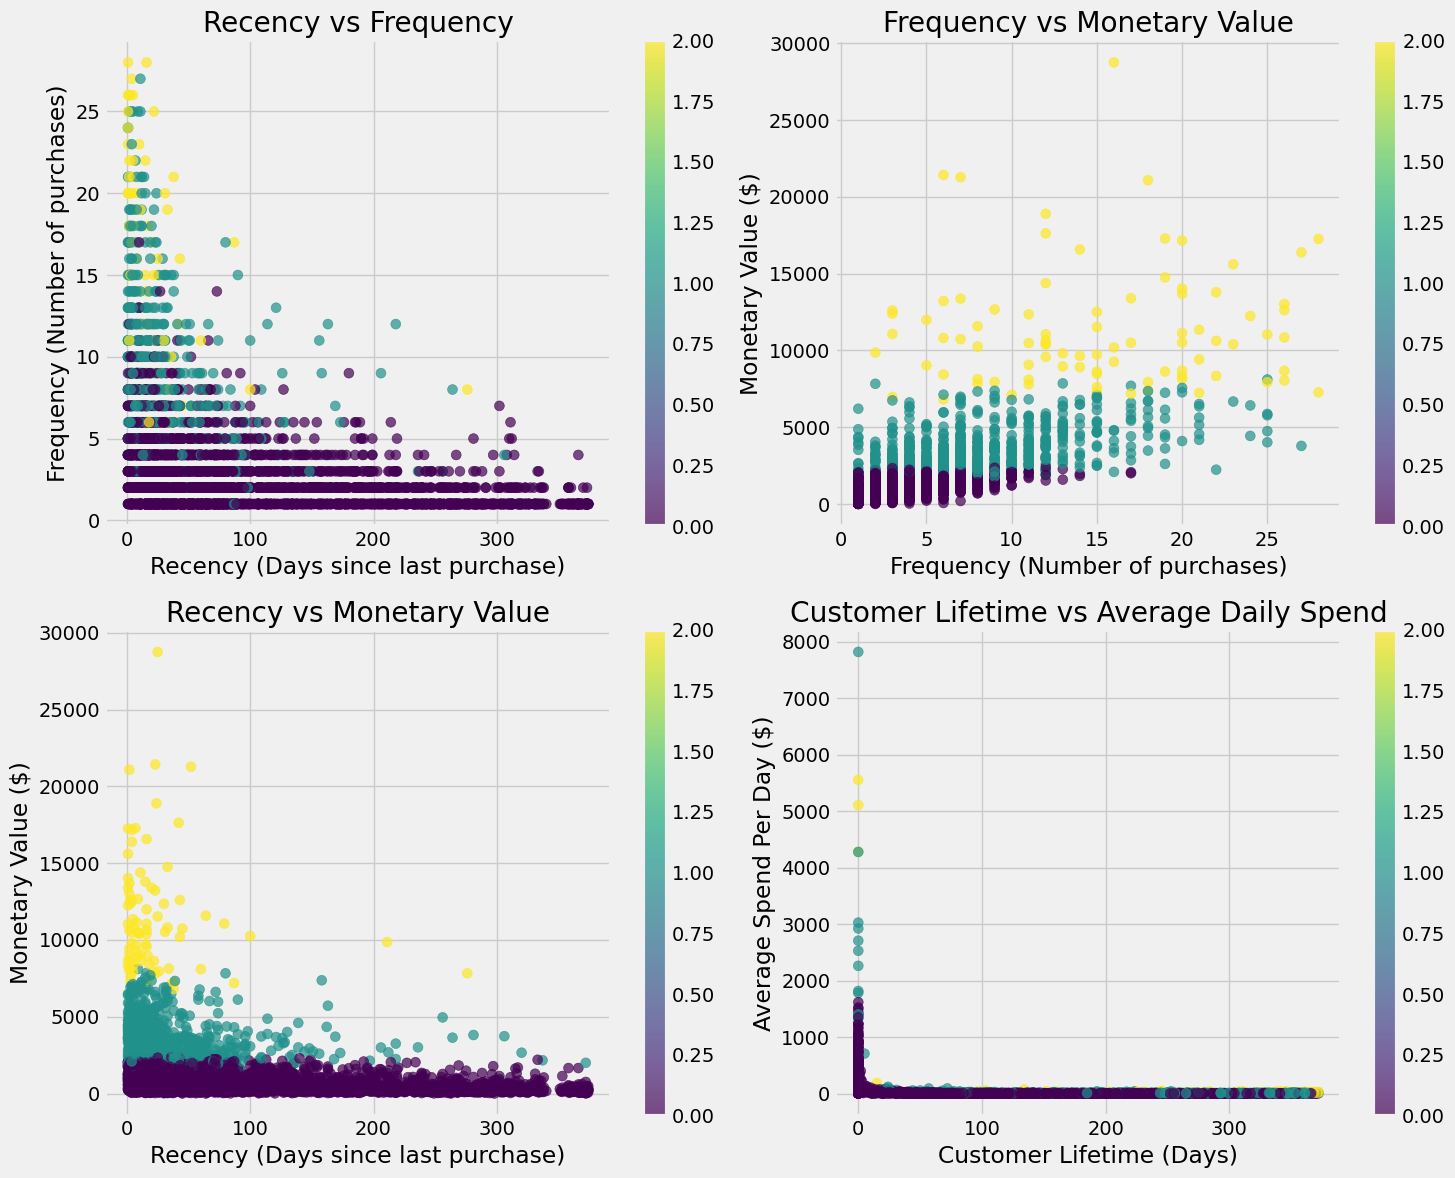

In [82]:
## Visualizing the Clusters

# First, merge cluster labels back to the original customer_features
# We need to align the cluster labels with the original data
customer_features_with_clusters = customer_features.copy()
customer_features_with_clusters['Cluster'] = np.nan  # Initialize with NaN

# Assign clusters only to the rows that were kept after outlier removal
customer_features_with_clusters.loc[X_filtered.index, 'Cluster'] = kmeans.labels_

# Now use this merged DataFrame for visualization
rfm_features = ['Recency', 'Frequency', 'MonetaryLog']
plot_df = customer_features_with_clusters[rfm_features + ['Cluster']].copy()
plot_df['Monetary'] = np.expm1(plot_df['MonetaryLog'])  # Convert back to original scale for interpretation

plt.figure(figsize=(15, 12))
sns.pairplot(plot_df, hue='Cluster', palette='viridis', diag_kind='kde', 
             plot_kws={'alpha': 0.6, 's': 30})
plt.suptitle('RFM Analysis: Pairwise Relationships Colored by Cluster', y=1.02)
plt.show()

# 2D Scatter plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Recency vs Frequency
scatter1 = axes[0, 0].scatter(plot_df['Recency'], plot_df['Frequency'], 
                             c=plot_df['Cluster'], cmap='viridis', alpha=0.7, s=50)
axes[0, 0].set_xlabel('Recency (Days since last purchase)')
axes[0, 0].set_ylabel('Frequency (Number of purchases)')
axes[0, 0].set_title('Recency vs Frequency')
plt.colorbar(scatter1, ax=axes[0, 0])

# Plot 2: Frequency vs Monetary
scatter2 = axes[0, 1].scatter(plot_df['Frequency'], plot_df['Monetary'], 
                             c=plot_df['Cluster'], cmap='viridis', alpha=0.7, s=50)
axes[0, 1].set_xlabel('Frequency (Number of purchases)')
axes[0, 1].set_ylabel('Monetary Value ($)')
axes[0, 1].set_title('Frequency vs Monetary Value')
axes[0, 1].ticklabel_format(style='plain', axis='y')
plt.colorbar(scatter2, ax=axes[0, 1])

# Plot 3: Recency vs Monetary
scatter3 = axes[1, 0].scatter(plot_df['Recency'], plot_df['Monetary'], 
                             c=plot_df['Cluster'], cmap='viridis', alpha=0.7, s=50)
axes[1, 0].set_xlabel('Recency (Days since last purchase)')
axes[1, 0].set_ylabel('Monetary Value ($)')
axes[1, 0].set_title('Recency vs Monetary Value')
axes[1, 0].ticklabel_format(style='plain', axis='y')
plt.colorbar(scatter3, ax=axes[1, 0])

# Plot 4: Customer Lifetime vs Avg Spend Per Day
# Make sure these columns exist in customer_features_with_clusters
if 'CustomerLifetime' in customer_features_with_clusters.columns and 'AvgSpendPerDay' in customer_features_with_clusters.columns:
    scatter4 = axes[1, 1].scatter(customer_features_with_clusters['CustomerLifetime'], 
                                 customer_features_with_clusters['AvgSpendPerDay'], 
                                 c=customer_features_with_clusters['Cluster'], cmap='viridis', alpha=0.7, s=50)
    axes[1, 1].set_xlabel('Customer Lifetime (Days)')
    axes[1, 1].set_ylabel('Average Spend Per Day ($)')
    axes[1, 1].set_title('Customer Lifetime vs Average Daily Spend')
    axes[1, 1].ticklabel_format(style='plain', axis='y')
    plt.colorbar(scatter4, ax=axes[1, 1])
else:
    # If these columns don't exist, hide the subplot or show a message
    axes[1, 1].set_visible(False)
    print("Warning: 'CustomerLifetime' or 'AvgSpendPerDay' columns not found. Hiding the subplot.")

plt.tight_layout()
plt.show()

Cluster Summary Statistics:
        Recency         Frequency        Monetary          UniqueProducts  \
           mean     std      mean   std      mean      std           mean   
Cluster                                                                     
0.0      106.88  103.75      2.44  1.89    669.61   533.85          40.41   
1.0       35.20   46.96      8.31  4.72   3631.91  1349.54         120.33   
2.0       23.31   39.86     15.01  6.89  11353.87  3919.80         148.38   

               CustomerLifetime         AvgSpendPerDay          
           std             mean     std           mean     std  
Cluster                                                         
0.0      40.26            97.10  116.53          92.38  164.06  
1.0      68.91           259.13   94.83          65.31  446.26  
2.0      91.06           300.29   91.31         195.76  921.13  


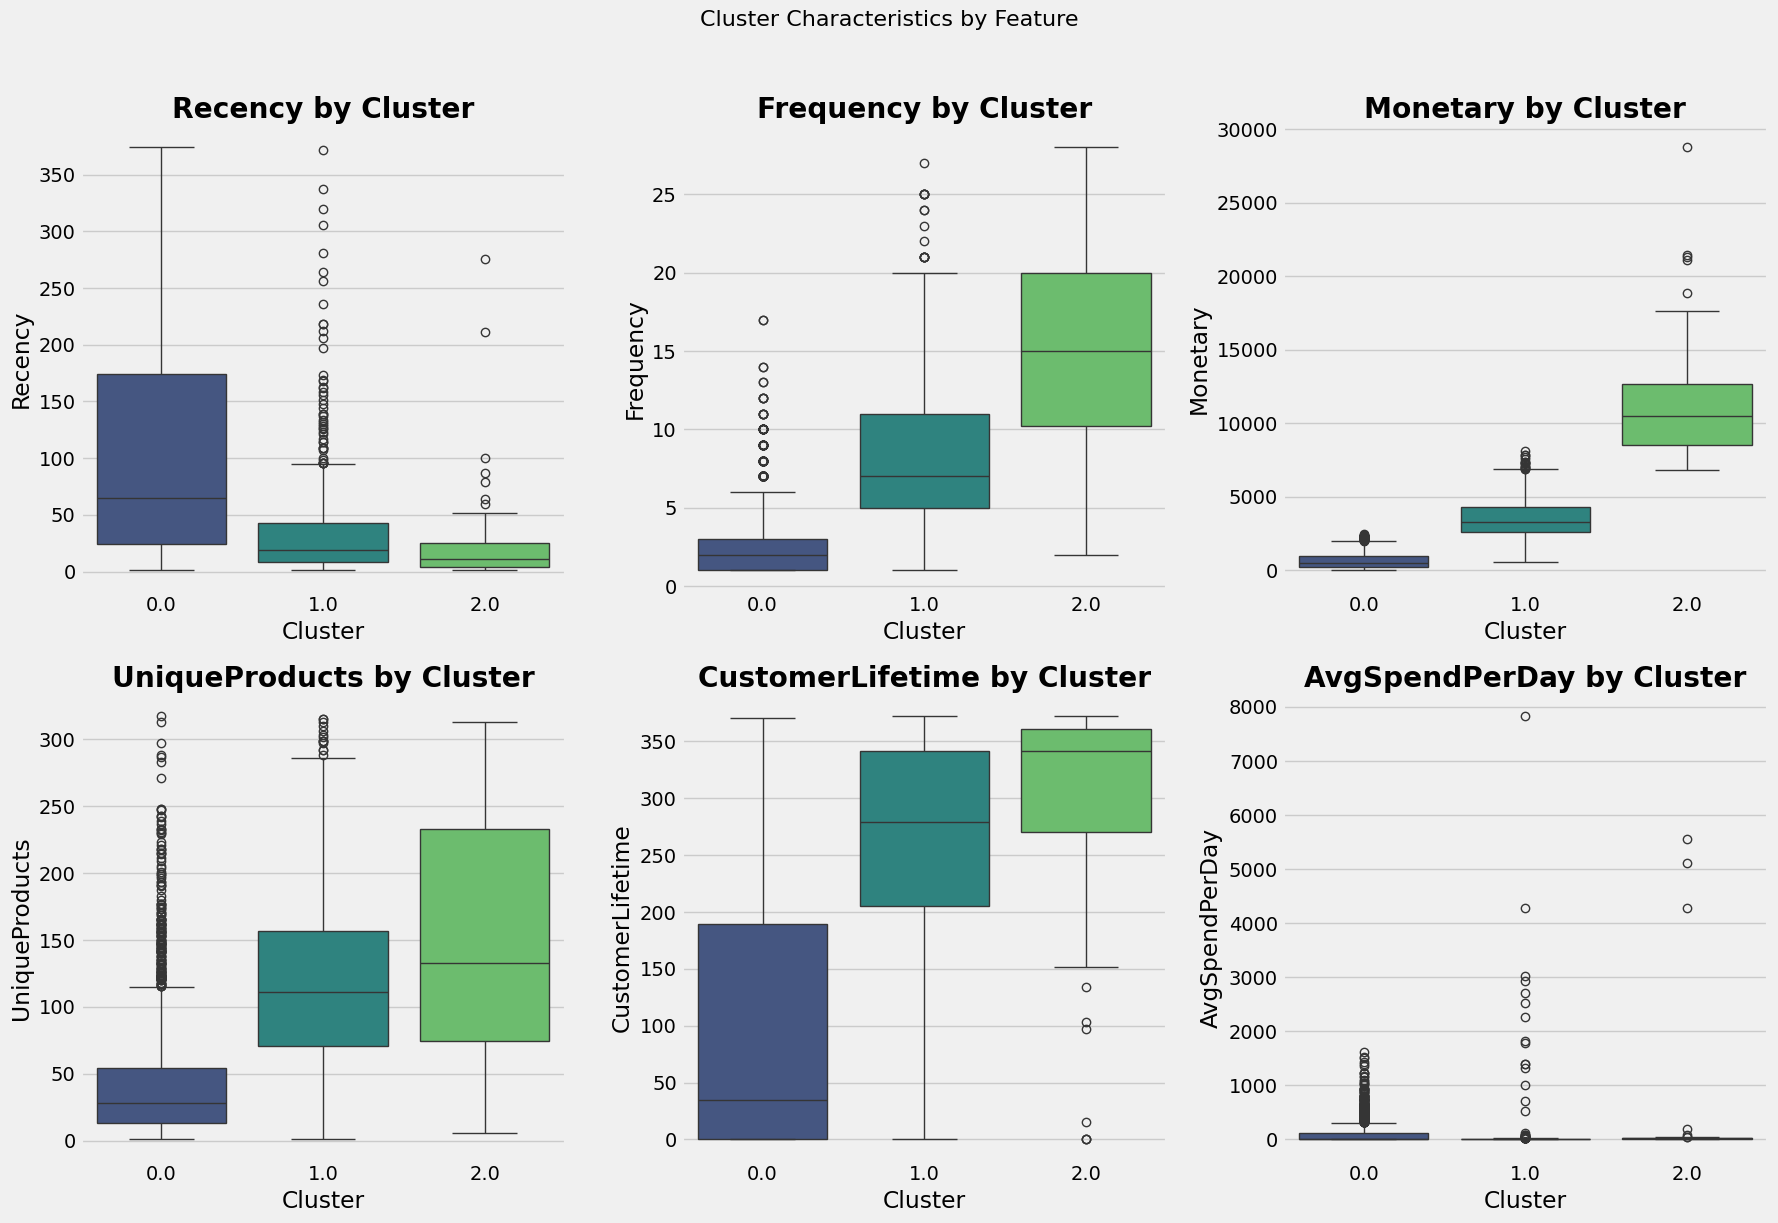


CLUSTER INTERPRETATION:

Cluster 0 (n=3503 customers):
  - Recency: 106.9 days since last purchase
  - Frequency: 2.4 purchases
  - Monetary: $669.61 total spending
  - Unique Products: 40.4 different items
  - Customer Lifetime: 97.1 days
  - Avg Spend/Day: $92.38
  Comparison to average:
    - Recency: +13.3%
    - Frequency: -32.0%
    - Monetary: -49.9%

Cluster 1 (n=641 customers):
  - Recency: 35.2 days since last purchase
  - Frequency: 8.3 purchases
  - Monetary: $3631.91 total spending
  - Unique Products: 120.3 different items
  - Customer Lifetime: 259.1 days
  - Avg Spend/Day: $65.31
  Comparison to average:
    - Recency: -62.7%
    - Frequency: +132.0%
    - Monetary: +171.9%

Cluster 2 (n=86 customers):
  - Recency: 23.3 days since last purchase
  - Frequency: 15.0 purchases
  - Monetary: $11353.87 total spending
  - Unique Products: 148.4 different items
  - Customer Lifetime: 300.3 days
  - Avg Spend/Day: $195.76
  Comparison to average:
    - Recency: -75.3%
    - Fr

In [84]:
## Cluster Analysis and Interpretation
# Analyze cluster characteristics
cluster_summary = customer_features_with_clusters.groupby('Cluster').agg({
    'Recency': ['mean', 'std'],
    'Frequency': ['mean', 'std'],
    'Monetary': ['mean', 'std'],
    'UniqueProducts': ['mean', 'std'],
    'CustomerLifetime': ['mean', 'std'],
    'AvgSpendPerDay': ['mean', 'std']
}).round(2)

print("Cluster Summary Statistics:")
print(cluster_summary)

# Visualize cluster characteristics
features_to_plot = ['Recency', 'Frequency', 'Monetary', 'UniqueProducts', 'CustomerLifetime', 'AvgSpendPerDay']
n_features = len(features_to_plot)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Cluster Characteristics by Feature', fontsize=16, y=1.02)

axes = axes.flatten()

for i, feature in enumerate(features_to_plot):
    sns.boxplot(x='Cluster', y=feature, data=customer_features_with_clusters, ax=axes[i], palette='viridis')
    axes[i].set_title(f'{feature} by Cluster', fontweight='bold')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(feature)
    
    # Format monetary values
    if feature in ['Monetary', 'AvgSpendPerDay']:
        axes[i].ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

# Interpret each cluster
print("\nCLUSTER INTERPRETATION:")
# Calculate overall means using only the non-outlier data that was clustered
overall_means = customer_features_with_clusters[customer_features_with_clusters['Cluster'].notna()].mean()

for cluster_id in range(optimal_k):
    cluster_data = customer_features_with_clusters[customer_features_with_clusters['Cluster'] == cluster_id]
    
    print(f"\nCluster {cluster_id} (n={len(cluster_data)} customers):")
    print(f"  - Recency: {cluster_data['Recency'].mean():.1f} days since last purchase")
    print(f"  - Frequency: {cluster_data['Frequency'].mean():.1f} purchases")
    print(f"  - Monetary: ${cluster_data['Monetary'].mean():.2f} total spending")
    print(f"  - Unique Products: {cluster_data['UniqueProducts'].mean():.1f} different items")
    print(f"  - Customer Lifetime: {cluster_data['CustomerLifetime'].mean():.1f} days")
    print(f"  - Avg Spend/Day: ${cluster_data['AvgSpendPerDay'].mean():.2f}")
    
    # Compare to overall averages
    recency_diff = (cluster_data['Recency'].mean() - overall_means['Recency']) / overall_means['Recency'] * 100
    freq_diff = (cluster_data['Frequency'].mean() - overall_means['Frequency']) / overall_means['Frequency'] * 100
    monetary_diff = (cluster_data['Monetary'].mean() - overall_means['Monetary']) / overall_means['Monetary'] * 100
    
    print(f"  Comparison to average:")
    print(f"    - Recency: {recency_diff:+.1f}%")
    print(f"    - Frequency: {freq_diff:+.1f}%")
    print(f"    - Monetary: {monetary_diff:+.1f}%")

Original samples: 4230
After outlier removal: 3953
Outliers removed: 277
X_scaled shape: (3953, 7)
Number of labels: 3953
Number of rows in X_scaled: 3953
Cluster sizes:
Cluster
0    1539
1    1705
2     709
Name: count, dtype: int64


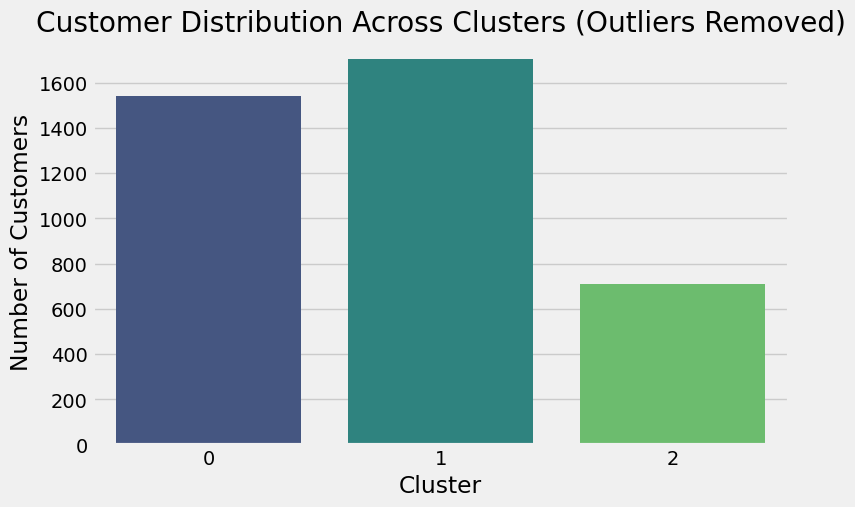


Cluster Centers (Original Scale):
   Recency  Frequency  MonetaryLog  UniqueProducts  TotalQuantity  \
0    58.62       3.15         6.65           48.39         524.60   
1   161.54       1.19         5.56           21.68         190.13   
2    31.83       7.21         7.87          110.12        1688.92   

   CustomerLifetime  AvgSpendPerDay  Cluster  
0            170.61            6.18        0  
1              6.18          166.78        1  
2            269.96            8.63        2  


In [89]:
# -------------------------------
# Outlier Removal FIRST
# -------------------------------

# Assuming features_for_clustering contains the columns you want to use
X = customer_features[features_for_clustering].copy()

# Calculate Z-scores and filter outliers (|Z-score| < 3)
z_scores = np.abs(stats.zscore(X))
filter_mask = (z_scores < 3).all(axis=1)
X_filtered = X[filter_mask].copy()

print(f"Original samples: {len(X)}")
print(f"After outlier removal: {len(X_filtered)}")
print(f"Outliers removed: {len(X) - len(X_filtered)}")

# -------------------------------
# Feature Scaling (on FILTERED data only)
# -------------------------------

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filtered)  # Scale ONLY the filtered data

print(f"X_scaled shape: {X_scaled.shape}")  # Should be (4230, 7)

# -------------------------------
# K-Means Clustering (on scaled, FILTERED data)
# -------------------------------

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20, max_iter=300)
kmeans.fit(X_scaled)

print(f"Number of labels: {len(kmeans.labels_)}")  # Should be 4230
print(f"Number of rows in X_scaled: {X_scaled.shape[0]}")  # Should be 4230

# Create customer_clusters from the filtered data
customer_clusters = customer_features.loc[X_filtered.index].copy()
customer_clusters.reset_index(drop=True, inplace=True)

# Now assign clusters - should match perfectly (both 4230)
customer_clusters['Cluster'] = kmeans.labels_

print("Cluster sizes:")
cluster_counts = customer_clusters['Cluster'].value_counts().sort_index()
print(cluster_counts)

# Plot cluster distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')
plt.title('Customer Distribution Across Clusters (Outliers Removed)')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()

# Compute cluster centers in original scale
cluster_centers_original = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers_df = pd.DataFrame(cluster_centers_original, columns=features_for_clustering)
cluster_centers_df['Cluster'] = range(optimal_k)

print("\nCluster Centers (Original Scale):")
print(cluster_centers_df.round(2))

In [91]:
## Business Implications and Recommendations
print("BUSINESS IMPLICATIONS AND RECOMMENDATIONS")
print("=" * 50)

# Make sure we're using the DataFrame that has the cluster labels
for cluster_id in range(optimal_k):
    cluster_data = customer_clusters[customer_clusters['Cluster'] == cluster_id]  # Use customer_clusters, not customer_features
    
    print(f"\nCLUSTER {cluster_id} PROFILE:")
    print(f"Size: {len(cluster_data)} customers ({len(cluster_data)/len(customer_clusters):.1%} of total)")
    
    # Check if these columns exist in your customer_clusters DataFrame
    # If not, you may need to adjust the column names
    recency = cluster_data['PurchaseFrequency'].mean() if 'Recency' not in cluster_data.columns else cluster_data['Recency'].mean()
    frequency = cluster_data['PurchaseFrequency'].mean() if 'Frequency' not in cluster_data.columns else cluster_data['Frequency'].mean()
    monetary = cluster_data['TotalSpend'].mean() if 'Monetary' not in cluster_data.columns else cluster_data['Monetary'].mean()
    lifetime = cluster_data['CustomerLifetime'].mean() if 'CustomerLifetime' not in cluster_data.columns else cluster_data['CustomerLifetime'].mean()
    
    print(f"Key Characteristics:")
    print(f"  - Avg Recency: {recency:.1f} days")
    print(f"  - Avg Frequency: {frequency:.1f} purchases")
    print(f"  - Avg Monetary: ${monetary:.2f}")
    print(f"  - Avg Lifetime: {lifetime:.1f} days")
    
    # Business recommendations
    print("Recommended Strategies:")
    if recency < 30 and frequency > 5:
        print("  - Champions: Offer premium products and exclusive early access")
        print("  - Implement VIP loyalty program with special benefits")
    elif recency < 90 and monetary > 500:
        print("  - Loyal Customers: Cross-sell complementary products")
        print("  - Offer volume discounts for frequent purchases")
    elif recency < 180:
        print("  - At Risk: Reactivation campaigns with special discounts")
        print("  - Personalized recommendations based on purchase history")
    else:
        print("  - Lost Customers: Win-back campaigns with significant incentives")
        print("  - Survey to understand reasons for churn")

# Overall recommendations
print(f"\nOVERALL RECOMMENDATIONS:")
print("- Implement segmented email marketing campaigns")
print("- Develop cluster-specific loyalty programs")
print("- Create personalized product recommendations")
print("- Monitor customer migration between clusters")
print("- Use clustering for customer lifetime value prediction")
print("- Develop retention strategies for at-risk segments")

BUSINESS IMPLICATIONS AND RECOMMENDATIONS

CLUSTER 0 PROFILE:
Size: 1539 customers (38.9% of total)
Key Characteristics:
  - Avg Recency: 58.6 days
  - Avg Frequency: 3.2 purchases
  - Avg Monetary: $914.35
  - Avg Lifetime: 170.6 days
Recommended Strategies:
  - Loyal Customers: Cross-sell complementary products
  - Offer volume discounts for frequent purchases

CLUSTER 1 PROFILE:
Size: 1705 customers (43.1% of total)
Key Characteristics:
  - Avg Recency: 161.5 days
  - Avg Frequency: 1.2 purchases
  - Avg Monetary: $333.94
  - Avg Lifetime: 6.2 days
Recommended Strategies:
  - At Risk: Reactivation campaigns with special discounts
  - Personalized recommendations based on purchase history

CLUSTER 2 PROFILE:
Size: 709 customers (17.9% of total)
Key Characteristics:
  - Avg Recency: 31.7 days
  - Avg Frequency: 7.2 purchases
  - Avg Monetary: $2921.54
  - Avg Lifetime: 270.1 days
Recommended Strategies:
  - Loyal Customers: Cross-sell complementary products
  - Offer volume discounts 

In [93]:
## Saving the Results
# Save the clustered customer data
output_df = customer_features_with_clusters.copy()

# Add original customer information
customer_country = df_clean.groupby('CustomerID')['Country'].first()
output_df = output_df.merge(customer_country, on='CustomerID', how='left')

# Save to CSV
output_df.to_csv('online_retail_customers_clustered.csv', index=False)
print("Clustered customer data saved to 'online_retail_customers_clustered.csv'")

# Save cluster centers
cluster_centers_df.to_csv('online_retail_cluster_centers.csv', index=False)
print("Cluster centers saved to 'online_retail_cluster_centers.csv'")

# Save cluster statistics - use the DataFrame with cluster labels
cluster_stats = customer_features_with_clusters.groupby('Cluster').agg({
    'Recency': ['mean', 'std', 'min', 'max'],
    'Frequency': ['mean', 'std', 'min', 'max'],
    'Monetary': ['mean', 'std', 'min', 'max'],
    'UniqueProducts': ['mean', 'std'],
    'CustomerLifetime': ['mean', 'std']
}).round(2)
cluster_stats.to_csv('online_retail_cluster_statistics.csv')
print("Cluster statistics saved to 'online_retail_cluster_statistics.csv'")

# Display final output
print("\nFinal clustered customer data (first 10 rows):")
print(output_df.head(10))

Clustered customer data saved to 'online_retail_customers_clustered.csv'
Cluster centers saved to 'online_retail_cluster_centers.csv'
Cluster statistics saved to 'online_retail_cluster_statistics.csv'

Final clustered customer data (first 10 rows):
   CustomerID  Recency  Frequency  Monetary  MonetaryLog       FirstPurchase  \
0     12347.0        2          7   4310.00     8.368925 2010-12-07 14:57:00   
1     12348.0       75          4   1797.24     7.494564 2010-12-16 19:09:00   
2     12349.0       19          1   1757.55     7.472245 2011-11-21 09:51:00   
3     12350.0      310          1    334.40     5.815324 2011-02-02 16:01:00   
4     12352.0       36          8   2506.04     7.826858 2011-02-16 12:33:00   
5     12353.0      204          1     89.00     4.499810 2011-05-19 17:47:00   
6     12354.0      232          1   1079.40     6.985087 2011-04-21 13:11:00   
7     12355.0      214          1    459.40     6.132096 2011-05-09 13:49:00   
8     12356.0       23         

COUNTRY-WISE CLUSTER ANALYSIS:

Cluster Distribution in Top 5 Countries (%):

United Kingdom:
  Cluster 0: 84.0%
  Cluster 1: 14.3%
  Cluster 2: 1.7%

Germany:
  Cluster 0: 68.5%
  Cluster 1: 26.1%
  Cluster 2: 5.4%

France:
  Cluster 0: 70.6%
  Cluster 1: 22.4%
  Cluster 2: 7.1%

Spain:
  Cluster 0: 75.0%
  Cluster 1: 17.9%
  Cluster 2: 7.1%

Belgium:
  Cluster 0: 66.7%
  Cluster 1: 33.3%
  Cluster 2: 0.0%


<Figure size 1200x800 with 0 Axes>

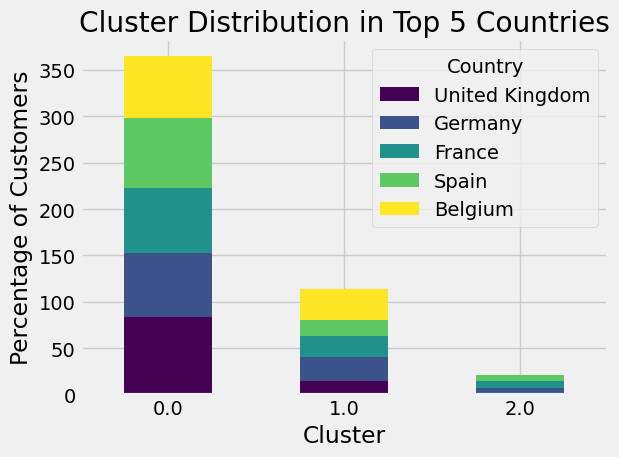

In [95]:
## Advanced Analysis: Country-wise Segmentation
if 'Country' in output_df.columns:
    print("COUNTRY-WISE CLUSTER ANALYSIS:")
    print("=" * 30)
    
    # Cluster distribution by country
    country_cluster = pd.crosstab(output_df['Country'], output_df['Cluster'])
    country_cluster_pct = country_cluster.div(country_cluster.sum(axis=1), axis=0) * 100
    
    # Top countries by customer count
    top_countries = output_df['Country'].value_counts().head(5).index
    
    print("\nCluster Distribution in Top 5 Countries (%):")
    for country in top_countries:
        if country in country_cluster_pct.index:
            print(f"\n{country}:")
            for cluster_id in range(optimal_k):
                pct = country_cluster_pct.loc[country, cluster_id]
                print(f"  Cluster {cluster_id}: {pct:.1f}%")
    
    # Visualize cluster distribution by country
    plt.figure(figsize=(12, 8))
    country_cluster_pct.loc[top_countries].T.plot(kind='bar', stacked=True, colormap='viridis')
    plt.title('Cluster Distribution in Top 5 Countries')
    plt.xlabel('Cluster')
    plt.ylabel('Percentage of Customers')
    plt.legend(title='Country')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [96]:
## Conclusion and Next Steps
print("PROJECT CONCLUSION AND NEXT STEPS")
print("=" * 40)

print(f"\nSuccessfully segmented {len(customer_features)} retail customers into {optimal_k} distinct clusters.")
print("Key insights gained from RFM analysis:")
print("- Identified customer segments based on purchasing behavior")
print("- Discovered patterns in customer value and loyalty")
print("- Established foundation for targeted marketing strategies")

print("\nRecommended Next Steps:")
print("1. Validate clusters with business stakeholders")
print("2. Develop segment-specific marketing campaigns")
print("3. Implement customer journey mapping for each segment")
print("4. Build predictive models for customer lifetime value")
print("5. Create automated cluster monitoring system")

print("\nTechnical Follow-ups:")
print("- Experiment with different clustering algorithms")
print("- Incorporate temporal patterns and seasonality")
print("- Add product category preferences to segmentation")
print("- Build real-time clustering pipeline")
print("- Integrate with CRM system for automated targeting")

PROJECT CONCLUSION AND NEXT STEPS

Successfully segmented 4230 retail customers into 3 distinct clusters.
Key insights gained from RFM analysis:
- Identified customer segments based on purchasing behavior
- Discovered patterns in customer value and loyalty
- Established foundation for targeted marketing strategies

Recommended Next Steps:
1. Validate clusters with business stakeholders
2. Develop segment-specific marketing campaigns
3. Implement customer journey mapping for each segment
4. Build predictive models for customer lifetime value
5. Create automated cluster monitoring system

Technical Follow-ups:
- Experiment with different clustering algorithms
- Incorporate temporal patterns and seasonality
- Add product category preferences to segmentation
- Build real-time clustering pipeline
- Integrate with CRM system for automated targeting
